# Initialize

In [54]:
%matplotlib notebook
import numpy as np
from scipy.special import wofz
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Functions
$ \sigma y = x $

In [55]:
def p_to_Conc(p, T):
    """ Returns the concentration based on a given pressure (Torr) and temperature (K) """
    return ((p*133.322)/(R*T))*Na

def G_HWHM(v_cent, T, M):
    """ Return Gaussian HWHM alpha based on line params """
    return (v_cent/c) * np.sqrt((2*Na*kb*T*np.log(2))/M)

def L_HWHM(g_air, g_self, p, p_self):
    """ Return Loren HWHM alpha based on line params """
    p_self = p_self * 0.00132
    p = p * 0.00132
    return g_air*(p-p_self)+g_self*p_self

def V_func(x, p_self, v_cent, M, g_air, g_self, S, v):
    """
    Return the Voigt line shape at x with Lorentzian component HWHM gamma
    and Gaussian component HWHM alpha.
    """

    
    sigma = (G_HWHM(v, Temp, M) / np.sqrt(2 * np.log(2)))/mA_wn_conv
    gamma = L_HWHM(g_air, g_self, p, p_self)/mA_wn_conv

    V_f = ((np.real(wofz(((x-v_cent) + 1j*gamma)/sigma/np.sqrt(2))) / sigma \
              /np.sqrt(2*np.pi))*S)*PL*p_to_Conc(p_self,Temp)/mA_wn_conv
    
    return V_f

def fit_func(x, p_self, offset, v1, v2, v3, v4):
    
    return V_func(x,p_self,v1,M_S1,g_air_S1L1,g_self_S1L1,S_S1L1,v_S1L1) \
        +V_func(x,p_self,v2,M_S1,g_air_S1L2,g_self_S1L2,S_S1L2,v_S1L2) \
        +V_func(x,p_self,v3,M_S1,g_air_S1L3,g_self_S1L3,S_S1L3,v_S1L3) \
        +V_func(x,p_self,v4,M_S1,g_air_S1L4,g_self_S1L4,S_S1L4,v_S1L4) \
        +offset

# Const and Params

In [56]:
""" Constants """
c = 2.998e10 #Speed of light, cm s-1
Na = 6.02214129e23 #Avogadro's number, mol-1
kb = 1.38064852e-16 # Boltzman Constant, cm2 g s-1 K-1
R = 8314000 # Gas Constant
Temp = 298 # Temp, K
p = 10 # Pressure, Torr
PL = 10 # path length,  cm
mA_wn_conv = 2.476E-02 # Conversion of mA to wavenumber


""" Species/Line params """
#Species 1 - H2O
M_S1 = 18.01528 # g mol-1
##Line 1
v_S1L1 = 3447.237010 # cm-1
g_air_S1L1 = 0.0728 # air broadening
g_self_S1L1 = 0.426 # self broadening
S_S1L1 = 5.381e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 2
v_S1L2 = 3447.076453 # cm-1
g_air_S1L2 = 0.0728 # air broadening
g_self_S1L2 = 0.412 # self broadening
S_S1L2 = 1.771e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 3
v_S1L3 = 3446.941250 # cm-1
g_air_S1L3 = 0.0862 # air broadening
g_self_S1L3 = 0.473 # self broadening
S_S1L3 = 1.836e-21 # Line strength, (molecule-1 cm2)/(cm-1)
##Line 4
v_S1L4 = 3446.884540 # cm-1
g_air_S1L4 = 0.049 # air broadening
g_self_S1L4 = 0.288 # self broadening
S_S1L4 = 5.297e-22 # Line strength, (molecule-1 cm2)/(cm-1)

## Import data and plot with initial guess

<IPython.core.display.Javascript object>


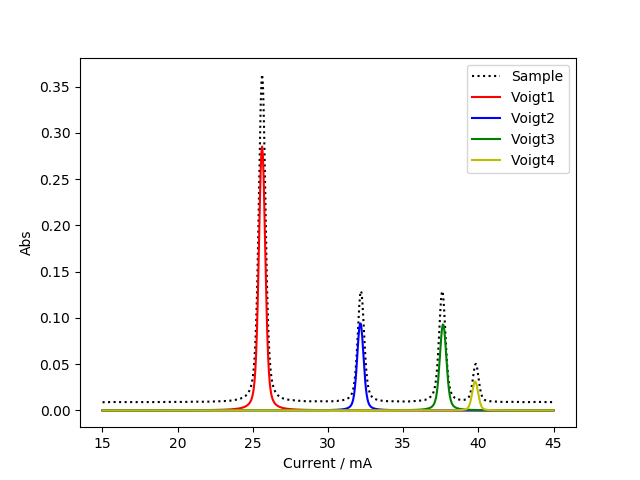

In [57]:
samp_file = r"C:\Users\winiberg\Desktop\Abs_Spec_Test.txt"
temp_data = np.genfromtxt(samp_file, dtype='f8')
x_data, samp_data = np.hsplit(temp_data,2)

#Flatten arrays so that fitting function works!
x_data = x_data.flatten()
samp_data = samp_data.flatten()

plt.plot(x_data, samp_data, ls=':', c='k', label='Sample')
plt.plot(x_data, V_func(x_data,2.5,25.621,M_S1,g_air_S1L1,g_self_S1L1,S_S1L1,v_S1L1), c='r', label='Voigt1')
plt.plot(x_data, V_func(x_data,2.5,32.157,M_S1,g_air_S1L2,g_self_S1L2,S_S1L2,v_S1L2), c='b', label='Voigt2')
plt.plot(x_data, V_func(x_data,2.5,37.656,M_S1,g_air_S1L3,g_self_S1L3,S_S1L3,v_S1L3), c='g', label='Voigt3')
plt.plot(x_data, V_func(x_data,2.5,39.79,M_S1,g_air_S1L4,g_self_S1L4,S_S1L4,v_S1L4), c='y', label='Voigt4')
plt.xlabel('Current / mA')
plt.ylabel('Abs')
plt.legend()
plt.show()

# Fit Data

[  3.27341113e+00   8.92267305e-03   2.56248559e+01   3.21954965e+01
   3.76021983e+01   3.98298753e+01]
1.06078417158e+17


<IPython.core.display.Javascript object>


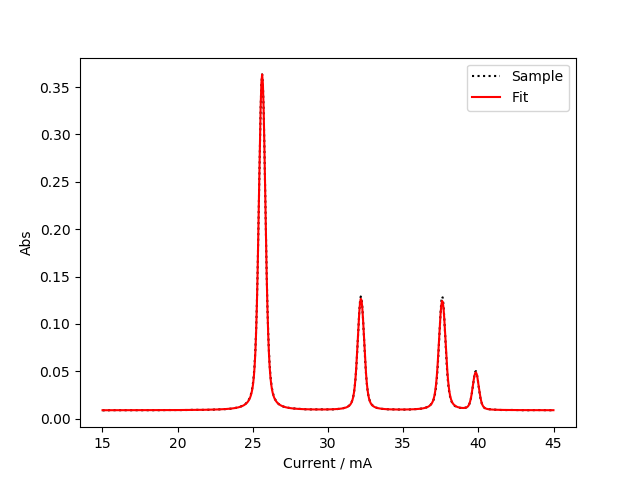

In [58]:
%matplotlib notebook
popt, pconv = curve_fit(fit_func,x_data,samp_data,p0=[1,0.01,25.621,32.157,37.656,39.79])

print(popt)
Conc1 = popt[0]
Offset = popt[1]
print(p_to_Conc(Conc1,Temp))

plt.plot(x_data, samp_data, ls=':', c='k', label='Sample')
plt.plot(x_data, fit_func(x_data, *popt), c='r', label='Fit')
plt.xlabel('Current / mA')
plt.ylabel('Abs')
plt.legend()
plt.show()
